In [133]:
import torch
import torch.utils.data
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

full_train_data = datasets.FashionMNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor())
full_test_data = datasets.FashionMNIST('../data', train=False, download=True,
                   transform=transforms.ToTensor())

In [135]:
def split_data(data,n):
    loader = torch.utils.data.DataLoader(data, batch_size=n, shuffle=False)
    X, Y = next(iter(loader))
    X = X.view(X.shape[0], -1).numpy()
    return X, Y

def calc_accuracy(preds, labels):
    score = np.sum([1 if pred==label else 0 for pred, label in zip(preds, labels)])
    return score/len(preds)

def fit_logit(model, X_test, X_train, y_test, y_train):
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    test = accuracy_score(y_pred_test, y_test)
    train = accuracy_score(y_pred_train, y_train)
    # attack accuracy
    attack = ((1-test)*len(y_test)+train*len(y_train))/(len(y_train)+len(y_test))
    return test, train, attack

n_lst = [100, 200, 400, 800, 1600, 2500, 5000, 10000]
train_acc_1,train_acc_2,test_acc_1,test_acc_2,attack_1,attack_2 = [], [], [], [], [], []
model_1 = LogisticRegression(max_iter=1500)
model_2 = LogisticRegression(C=0.01, penalty='l2', max_iter=1500)
for n in n_lst:
    # take the subset of data and split to X and Y
    X_train, y_train = split_data(full_train_data,n)
    X_test, y_test = split_data(full_test_data,n)
    # train a logistic regression model with no regularization
    test, train, attack = fit_logit(model_1, X_test, X_train, y_test, y_train)
    train_acc_1.append(train)
    test_acc_1.append(test)
    attack_1.append(attack)
    # train a logistic regression model with l2 regularization
    test, train, attack = fit_logit(model_2, X_test, X_train, y_test, y_train)
    train_acc_2.append(train)
    test_acc_2.append(test)
    attack_2.append(attack)


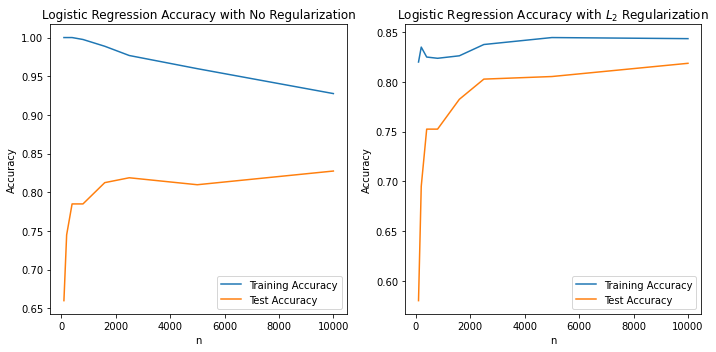

In [139]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(n_lst, train_acc_1, label='Training Accuracy')
plt.plot(n_lst, test_acc_1, label='Test Accuracy')
plt.xlabel('n')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Accuracy with No Regularization')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(n_lst, train_acc_2, label='Training Accuracy')
plt.plot(n_lst, test_acc_2, label='Test Accuracy')
plt.xlabel('n')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Accuracy with $L_2$ Regularization')
plt.legend()
plt.tight_layout()
plt.show()

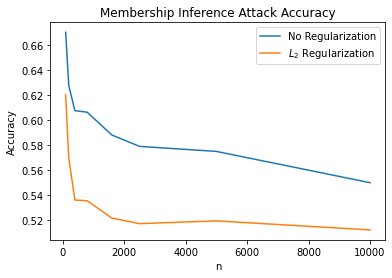

In [141]:
plt.plot(n_lst, attack_1, label='No Regularization')
plt.plot(n_lst, attack_2, label='$L_2$ Regularization')
plt.xlabel('n')
plt.ylabel('Accuracy')
plt.title('Membership Inference Attack Accuracy')
plt.legend()
plt.show()

In [147]:
def fit_logit_noise(model, X_test, X_train, y_test, y_train, sigma_sq):
    model.fit(X_train, y_train)
    # add random noise
    noise = np.random.normal(0, np.sqrt(sigma_sq), model.coef_.shape)
    model.coef_ += noise
    test = model.score(X_test, y_test)
    train = model.score(X_train, y_train)
    # attack accuracy
    attack = ((1-test)*len(y_test)+train*len(y_train))/(len(y_train)+len(y_test))
    return test, train, attack

train_noise_1,train_noise_2,test_noise_1,test_noise_2,attack_noise_1,attack_noise_2 = [], [], [], [], [], []
model_1 = LogisticRegression(max_iter=1000)
model_2 = LogisticRegression(C=0.1, penalty='l2', max_iter=1000)
sigma_sqs = np.linspace(0,5,15)
for sigma_sq in sigma_sqs:
    print(sigma_sq)
    # take the subset of data and split to X and Y
    X_train, y_train = split_data(full_train_data,n)
    X_test, y_test = split_data(full_test_data,n)
    # no reg
    test, train, attack=fit_logit_noise(model_1, X_test, X_train, y_test, y_train, sigma_sq)
    train_noise_1.append(train)
    test_noise_1.append(test)
    attack_noise_1.append(attack)
    # l2 reg
    test, train, attack=fit_logit_noise(model_2, X_test, X_train, y_test, y_train, sigma_sq)
    train_noise_2.append(train)
    test_noise_2.append(test)
    attack_noise_2.append(attack)
    

0.0
0.35714285714285715
0.7142857142857143
1.0714285714285714
1.4285714285714286
1.7857142857142858
2.142857142857143
2.5
2.857142857142857
3.2142857142857144
3.5714285714285716
3.928571428571429
4.285714285714286
4.642857142857143
5.0


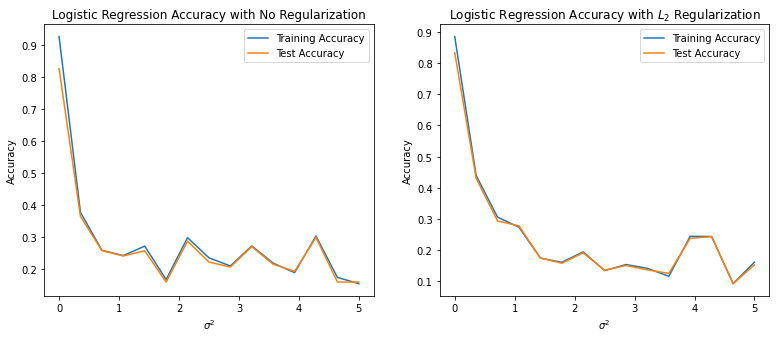

In [150]:
plt.figure(figsize=(13, 5))
plt.subplot(1, 2, 1)
plt.plot(sigma_sqs, train_noise_1, label='Training Accuracy')
plt.plot(sigma_sqs, test_noise_1, label='Test Accuracy')
plt.title('Logistic Regression Accuracy with No Regularization')
plt.xlabel('$\sigma^2$')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(sigma_sqs, train_noise_2, label='Training Accuracy')
plt.plot(sigma_sqs, test_noise_2, label='Test Accuracy')
plt.title('Logistic Regression Accuracy with $L_2$ Regularization')
plt.xlabel('$\sigma^2$')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



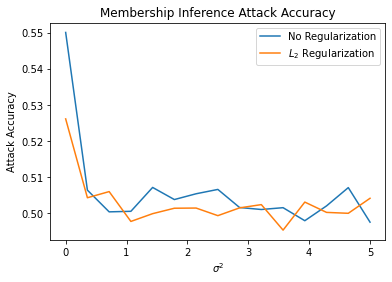

In [149]:
plt.plot(sigma_sqs, attack_noise_1, label='No Regularization')
plt.plot(sigma_sqs, attack_noise_2, label='$L_2$ Regularization')
plt.title('Membership Inference Attack Accuracy')
plt.xlabel('$\sigma^2$')
plt.ylabel('Attack Accuracy')
plt.legend()

plt.show()